Sparsh Patel 08/28/2025

## Importing basic Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import sklearn

sys.path.append('..')

In [3]:
os.chdir('/Users/sparshpatel/bootcamp_sparsh_patel')
print(os.getcwd())

/Users/sparshpatel/bootcamp_sparsh_patel


## Data Simulation

In [ ]:
import pandas as pd
import numpy as np


closing_prices = pd.read_csv("/Users/sparshpatel/bootcamp_sparsh_patel/project/data/processed/filtered_rounded_nse.csv", parse_dates=["Date"], index_col="Date")
returns_df = pd.read_csv("/Users/sparshpatel/bootcamp_sparsh_patel/project/data/processed/pct_change.csv", index_col=0)   # already computed % changes
stock_metrics = pd.read_csv("/Users/sparshpatel/bootcamp_sparsh_patel/project/data/processed/stock_metrics.csv", index_col=0)  # CAGR, volatility, etc.

tickers = returns_df.columns
chosen_stocks = np.random.choice(tickers, size=10, replace=False)
weights = np.random.random(len(chosen_stocks))
weights /= weights.sum()
portfolio_returns = (returns_df[chosen_stocks] * weights).sum(axis=1)
portfolio_cagr = ((1 + portfolio_returns.mean()) ** 252) - 1
portfolio_volatility = portfolio_returns.std() * np.sqrt(252)
sharpe_ratio = portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252)

print("Chosen Stocks:", chosen_stocks)
print("Weights:", weights.round(3))
print(f"Portfolio CAGR: {portfolio_cagr:.2%}")
print(f"Portfolio Volatility: {portfolio_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")


Chosen Stocks: ['DBL' 'BALKRISIND' 'HINDCOPPER' 'SAMHI' 'LAURUSLABS' 'SHAREINDIA'
 'HTMEDIA' 'JUSTDIAL' 'CAPACITE' 'HITECHGEAR']
Weights: [0.161 0.062 0.033 0.021 0.188 0.092 0.196 0.018 0.085 0.146]
Portfolio CAGR: 14.82%
Portfolio Volatility: 20.09%
Sharpe Ratio: 0.69


From the generated set, we can extract:

Max Sharpe Portfolio (best risk-adjusted return)

Min Volatility Portfolio (least risky)

### Now instead of one, we will make a 1000 random portfolios and run a simulation on them 


In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import random



mean_returns_daily = returns_df.mean()
cov_matrix_daily = returns_df.cov()


mean_returns = mean_returns_daily * annual_factor
cov_matrix = cov_matrix_daily * annual_factor

N_PORTFOLIOS = 1000  
min_holdings = 8
max_holdings = 15



def optimize_portfolio(portfolio_weights, mean_returns, cov_matrix):
    """
    Optimize a single portfolio (only non-zero stocks) using annualized returns/covariance
    """
    
    chosen_stocks = [stock for stock, w in portfolio_weights.items() if w > 0]
    mean_returns_sub = mean_returns[chosen_stocks]
    cov_matrix_sub = cov_matrix.loc[chosen_stocks, chosen_stocks]
    n = len(chosen_stocks)

    
    init_guess = np.array([1/n]*n)

    
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(n))

    
    def portfolio_volatility(weights):
        return np.sqrt(weights.T @ cov_matrix_sub.values @ weights)

    result = minimize(portfolio_volatility, init_guess, method='SLSQP', bounds=bounds, constraints=constraints)
    optimized_weights = dict(zip(chosen_stocks, result.x))
    min_vol = result.fun
    return optimized_weights, min_vol

def generate_random_portfolio(tickers, min_holdings, max_holdings):
    """
    Generate one random portfolio as a dict of stock -> weight
    """
    k = random.randint(min_holdings, max_holdings)
    chosen = random.sample(tickers, k)
    weights = np.random.random(k)
    weights /= weights.sum()
    return dict(zip(chosen, weights))


random_portfolios = [generate_random_portfolio(list(returns_df.columns), min_holdings, max_holdings)
                     for _ in range(N_PORTFOLIOS)]


optimized_results = []

for idx, port in enumerate(random_portfolios):
    opt_weights, min_vol = optimize_portfolio(port, mean_returns, cov_matrix)

    
    chosen_stocks = list(opt_weights.keys())
    weights_array = np.array(list(opt_weights.values()))
    exp_return = np.dot(mean_returns[chosen_stocks], weights_array)
    exp_vol = min_vol
    sharpe = exp_return / exp_vol if exp_vol != 0 else 0

    optimized_results.append({
        "Portfolio_ID": idx+1,
        "Stocks": chosen_stocks,
        "Weights": list(opt_weights.values()),
        "Expected_Return": exp_return,
        "Volatility": exp_vol,
        "Sharpe": sharpe
    })

optimized_df = pd.DataFrame(optimized_results)


pd.set_option("display.max_colwidth", None)
print(optimized_df.head())


optimized_df.to_csv("/Users/sparshpatel/bootcamp_sparsh_patel/project/data/processed/optimized_random_portfolios.csv", index=False)
print("✅ All optimized portfolios saved to CSV")

   Portfolio_ID  \
0             1   
1             2   
2             3   
3             4   
4             5   

                                                                                                                                          Stocks  \
0  [UNIVCABLES, NEOGEN, ARVIND, RUPA, AVG, AVADHSUGAR, LTIM, KALAMANDIR, GULPOLY, ULTRACEMCO, WOCKPHARMA, ZUARIIND, POWERMECH, PFOCUS, PNCINFRA]   
1            [CONCORDBIO, BAJAJELEC, VIKASECO, RADHIKAJWE, BIRLACORPN, NETWEB, FOODSIN, V2RETAIL, NUVAMA, BAJAJHIND, SCILAL, NAM-INDIA, DHANUKA]   
2                            [INDIGOPNTS, RAMCOCEM, DALBHARAT, UTIAMC, RGL, HITECH, SOBHA, BLS, FEDERALBNK, JSFB, JKTYRE, CHOLAHLDNG, ZYDUSLIFE]   
3                                                          [KELLTONTEC, AMBUJACEM, HMVL, TMB, RGL, ALICON, ATULAUTO, KHADIM, WEALTH, CHAMBLFERT]   
4                                 [PATELENG, TEGA, DIVGIITTS, PURVA, RAINBOW, HINDWAREAP, ASHAPURMIN, JAYBARMARU, BHARATWIRE, STAR, SBCL, SEMAC] 

### We have taken portfolios ranging from 8-15 stocks where around 3 stocks constitute over half the weighatge.
This mimics the portfolio of a common trader

## Visualizations

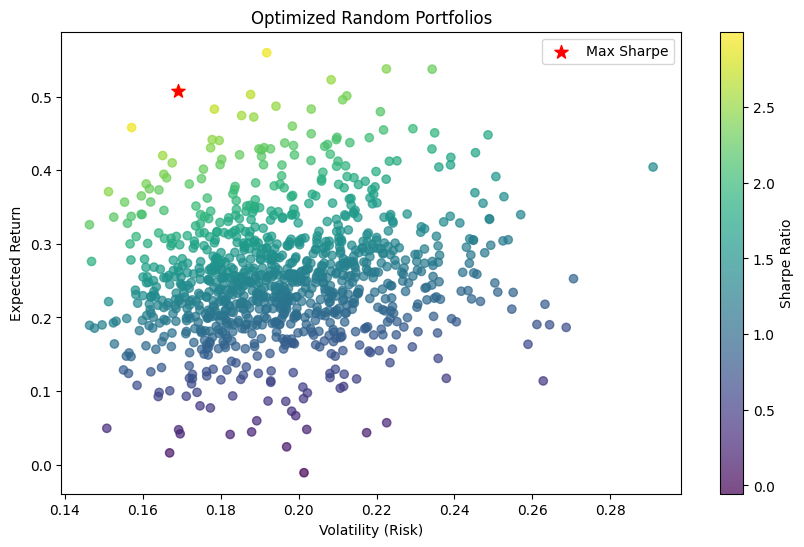

In [ ]:

plt.figure(figsize=(10,6))
plt.scatter(
    optimized_df['Volatility'], 
    optimized_df['Expected_Return'], 
    c=optimized_df['Sharpe'], 
    cmap='viridis', 
    alpha=0.7
)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility (Risk)')
plt.ylabel('Expected Return')
plt.title('Optimized Random Portfolios')
max_sharpe_idx = optimized_df['Sharpe'].idxmax()
plt.scatter(
    optimized_df.loc[max_sharpe_idx, 'Volatility'], 
    optimized_df.loc[max_sharpe_idx, 'Expected_Return'], 
    c='red', s=100, marker='*', label='Max Sharpe'
)
plt.legend()
plt.show()


### Picking top performing portfolios

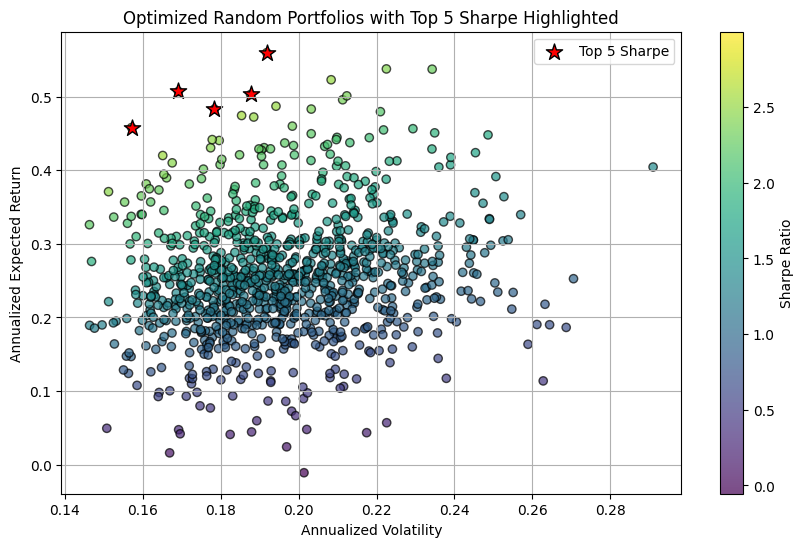

In [ ]:
import matplotlib.pyplot as plt

top_portfolios = optimized_df.nlargest(5, 'Sharpe')

plt.figure(figsize=(10,6))

plt.scatter(
    optimized_df['Volatility'], 
    optimized_df['Expected_Return'], 
    c=optimized_df['Sharpe'], 
    cmap='viridis', alpha=0.7, edgecolor='k'
)
plt.colorbar(label='Sharpe Ratio')

plt.scatter(
    top_portfolios['Volatility'], 
    top_portfolios['Expected_Return'], 
    c='red', s=150, marker='*', label='Top 5 Sharpe', edgecolor='k'
)

plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Expected Return')
plt.title('Optimized Random Portfolios with Top 5 Sharpe Highlighted')
plt.legend()
plt.grid(True)
plt.show()


### Performance Graph

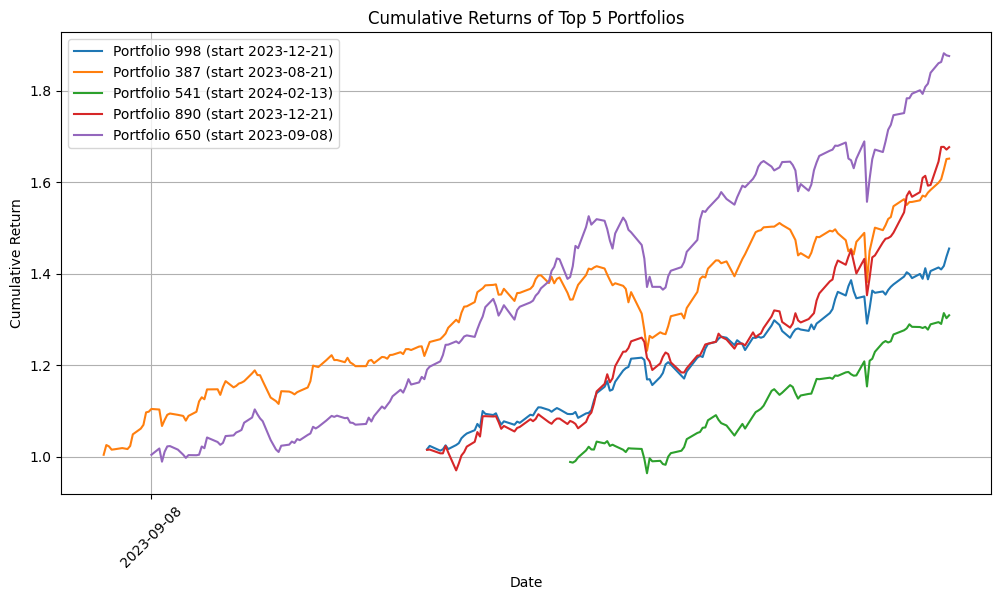

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


returns_df = returns_df.copy()
returns_df.index = pd.to_datetime(returns_df.index, errors='coerce')
returns_df = returns_df.sort_index()

plt.figure(figsize=(12,6))

for _, row in top_portfolios.iterrows():
    stocks  = row['Stocks']
    weights = np.array(row['Weights'], dtype=float)

    
    sub = returns_df[stocks].dropna(how='any')

    
    port_ret = sub.dot(weights)
    port_cum = (1 + port_ret).cumprod()

    start_date = pd.to_datetime(port_cum.index[0]).strftime('%Y-%m-%d')
    plt.plot(port_cum.index, port_cum.values, label=f"Portfolio {row['Portfolio_ID']} (start {start_date})")

plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Returns of Top 5 Portfolios')
plt.grid(True)
plt.legend()

if len(returns_df) > 260:
    xt = port_cum.index[::252]
    plt.xticks(xt, rotation=45)
plt.show()


### Classification of top portfolios

In [ ]:



results = []

for idx, row in top_portfolios.iterrows():
    stocks = row['Stocks']
    weights = row['Weights']
    
    
    daily_returns = returns_df[stocks].dot(np.array(weights))
    
    
    ann_return = (1 + daily_returns.mean())**252 - 1
    ann_vol = daily_returns.std() * np.sqrt(252)
    sharpe = (daily_returns.mean() * 252) / (daily_returns.std() * np.sqrt(252)) 
    
    results.append({
        "Portfolio_ID": row['Portfolio_ID'],
        "Annualized Return": ann_return,
        "Annualized Volatility": ann_vol,
        "Sharpe Ratio": sharpe
    })

metrics_df = pd.DataFrame(results).reset_index(drop=True)
metrics_df['Risk Profile'] = np.nan


used = set()

aggr_idx = metrics_df['Annualized Return'].idxmax()
metrics_df.loc[aggr_idx, 'Risk Profile'] = "Aggressive"
used.add(aggr_idx)

cons_idx = metrics_df['Annualized Volatility'].idxmin()
if cons_idx in used: 
    cons_idx = metrics_df.drop(index=list(used))['Annualized Volatility'].idxmin()
metrics_df.loc[cons_idx, 'Risk Profile'] = "Conservative"
used.add(cons_idx)


bal_idx = metrics_df['Sharpe Ratio'].idxmax()
if bal_idx in used: 
    bal_idx = metrics_df.drop(index=list(used))['Sharpe Ratio'].idxmax()
metrics_df.loc[bal_idx, 'Risk Profile'] = "Balanced"
used.add(bal_idx)

print(metrics_df)


   Portfolio_ID  Annualized Return  Annualized Volatility  Sharpe Ratio  \
0           998           1.089577               0.179622      4.108862   
1           387           0.841056               0.198913      3.072095   
2           541           1.066062               0.196634      3.695644   
3           890           1.768301               0.222694      4.581596   
4           650           1.258223               0.210804      3.870395   

   Risk Profile  
0  Conservative  
1           NaN  
2           NaN  
3    Aggressive  
4      Balanced  


/var/folders/qz/0dlc8y692_34_5qr067vqw540000gn/T/ipykernel_889/4033349063.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Aggressive' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  metrics_df.loc[aggr_idx, 'Risk Profile'] = "Aggressive"


Here we can see that portfolio 890 has both highest returns and sharpe ratio

### Classifying and ranking stocks from top performing portfolios

In [ ]:

all_stocks = []
weights_data = []

for idx, row in top_portfolios.head(5).iterrows():
    stocks = row['Stocks']
    weights = row['Weights']
    all_stocks.extend(stocks)
    weights_data.extend(list(zip(stocks, weights)))

stock_counts = Counter(all_stocks)

weights_df = pd.DataFrame(weights_data, columns=["Stock", "Weight"])
avg_weights = weights_df.groupby("Stock")["Weight"].mean().reset_index()

stock_summary = pd.DataFrame(stock_counts.items(), columns=["Stock", "Frequency"])
stock_summary = stock_summary.merge(avg_weights, on="Stock")

stock_summary = stock_summary.sort_values(by=["Frequency","Weight"], ascending=[False, False])

print(stock_summary)


         Stock  Frequency        Weight
22    CHOICEIN          3  3.238279e-01
8         LGHL          2  2.491721e-01
2         DOMS          2  1.542677e-01
31  PIDILITIND          1  2.434462e-01
7       HNDFDS          1  2.421304e-01
38  GODREJAGRO          1  2.111495e-01
4    EICHERMOT          1  2.072478e-01
48         OIL          1  2.067777e-01
36  SUPREMEIND          1  1.726493e-01
13  CONCORDBIO          1  1.699546e-01
46      360ONE          1  1.557141e-01
39    AXISBANK          1  1.484253e-01
28     ICICIGI          1  1.329171e-01
15   DIVGIITTS          1  1.286530e-01
16   LICHSGFIN          1  9.417888e-02
51     NIITMTS          1  8.986952e-02
23       CLSEL          1  8.672779e-02
45  IRISDOREME          1  7.924069e-02
34    KRISHANA          1  7.344168e-02
37  MOTILALOFS          1  7.280511e-02
42     TCLCONS          1  6.712131e-02
5   DCMSHRIRAM          1  6.551540e-02
40     POKARNA          1  6.275400e-02
20    RATEGAIN          1  5.655291e-02


In [31]:
stock_summary["Score"] = stock_summary["Frequency"] * stock_summary["Weight"]
stock_summary = stock_summary.sort_values(by="Score", ascending=False)

stock_summary 

,Stock,Frequency,Weight,Score
22,CHOICEIN,3,3.238279e-01,9.714836e-01
8,LGHL,2,2.491721e-01,4.983441e-01
2,DOMS,2,1.542677e-01,3.085354e-01
31,PIDILITIND,1,2.434462e-01,2.434462e-01
7,HNDFDS,1,2.421304e-01,2.421304e-01
38,GODREJAGRO,1,2.111495e-01,2.111495e-01
4,EICHERMOT,1,2.072478e-01,2.072478e-01
48,OIL,1,2.067777e-01,2.067777e-01
36,SUPREMEIND,1,1.726493e-01,1.726493e-01
13,CONCORDBIO,1,1.699546e-01,1.699546e-01


### Finalising top performing stocks

In [ ]:

stock_summary["Score"] = stock_summary["Frequency"] * stock_summary["Weight"]
stock_summary_sorted = stock_summary.sort_values(by="Score", ascending=False)
top_10 = stock_summary_sorted.head(10)[["Stock", "Score"]]

print(top_10['Stock'])


22      CHOICEIN
8           LGHL
2           DOMS
31    PIDILITIND
7         HNDFDS
38    GODREJAGRO
4      EICHERMOT
48           OIL
36    SUPREMEIND
13    CONCORDBIO
Name: Stock, dtype: object


## Final Presentation

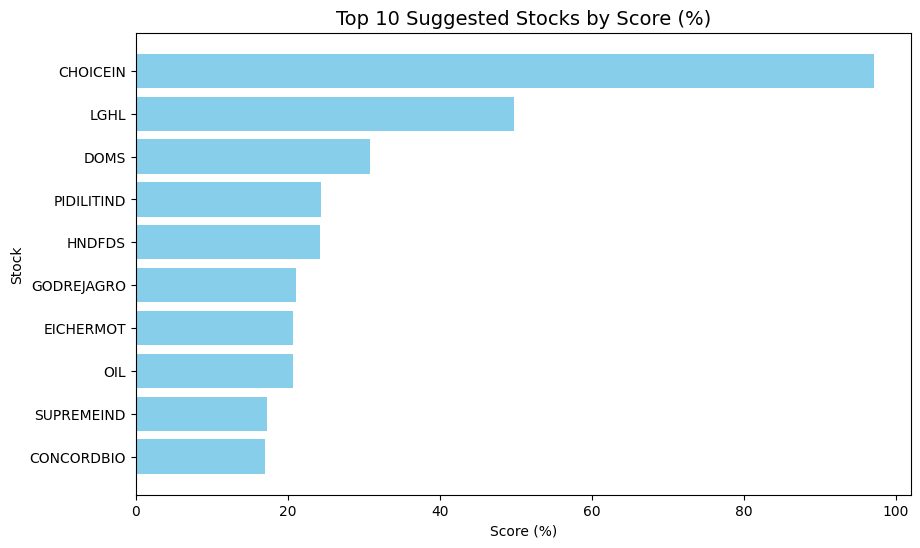

In [38]:
top_10["Score %"] = top_10["Score"] * 100

plt.figure(figsize=(10,6))
plt.barh(top_10["Stock"], top_10["Score %"], color="skyblue")
plt.gca().invert_yaxis()
plt.title("Top 10 Suggested Stocks by Score (%)", fontsize=14)
plt.xlabel("Score (%)")
plt.ylabel("Stock")
plt.show()


In [41]:
pip install squarify


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


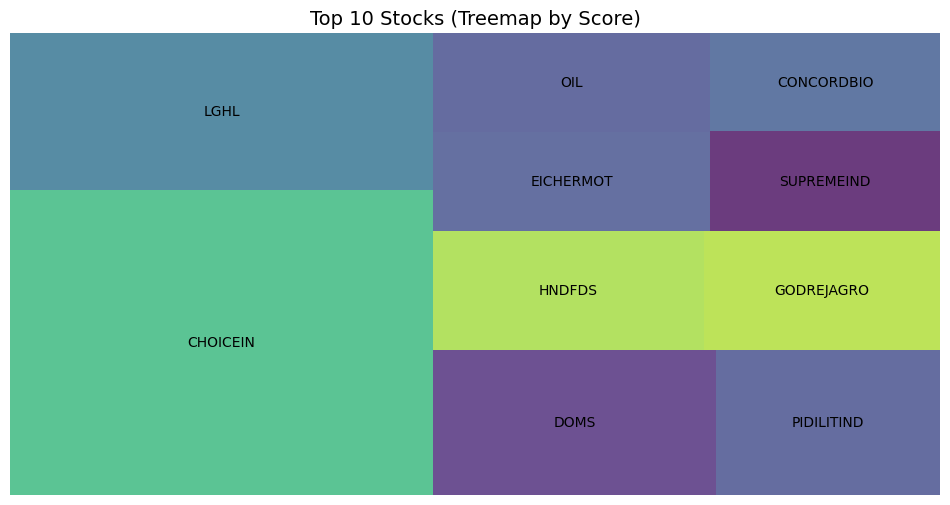

In [42]:

import squarify

plt.figure(figsize=(12,6))
squarify.plot(sizes=top_10["Score"], 
              label=top_10["Stock"], 
              alpha=0.8)
plt.title("Top 10 Stocks (Treemap by Score)", fontsize=14)
plt.axis("off")
plt.show()
